In [29]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
from PublicDataReader import Ecos
from datetime import date

service_key = "2G5XUDEN750MGRZM37GF"
api = Ecos(service_key)

# 행(row) 다 보기
pd.set_option('display.max_rows', None)

# 열(column) 다 보기
pd.set_option('display.max_columns', None)

### 환율
- 달러인덱스(DXY)는 유로, 엔, 파운드 등 주요국 통화 대비 달러의 강약을 보여주는 글로벌 지표
- 원/달러 환율은 한국 원화 대비 달러의 상대가치

In [2]:
df_dollar = yf.download(["USDKRW=X", "DX-Y.NYB"], start='2020-01-01', end='2027-11-01', auto_adjust=True)

[*********************100%***********************]  2 of 2 completed


In [3]:
df_close = df_dollar[[( 'Close', 'DX-Y.NYB'), ( 'Close', 'USDKRW=X')]]
df_close = df_close.dropna()
df_close.columns = ['_'.join(col).strip() for col in df_close.columns.values]
df_close.head()


,Close_DX-Y.NYB,Close_USDKRW=X
Date,,
2020-01-02,96.849998,1153.969971
2020-01-03,96.839996,1157.150024
2020-01-06,96.669998,1165.849976
2020-01-07,96.980003,1167.420044
2020-01-08,97.300003,1166.459961


- DXY ↑ + USD/KRW ↑ , 달러 강세, 원화 약세 (외국인 자금 이탈 가능성)
- DXY ↓ + USD/KRW ↓ , 달러 약세, 원화 강세 (수입기업 유리)
- DXY ↑ + USD/KRW ↓ , 글로벌 달러 강세지만 한국 원화만 강세 (특이한 자본유입)
- 2020년 이후, 원화가 약세인데 달러도 약세인 현상은 상당히 이례적임
    + 한국통화에 대한 신뢰 하락 또는 한국 자산에 대한 투자심리 악화
    + 한국 고유 리스크 요인, 무역수지 악(수출부진, 수출급증), 미국금리 차이 확대, 원화가 비주류

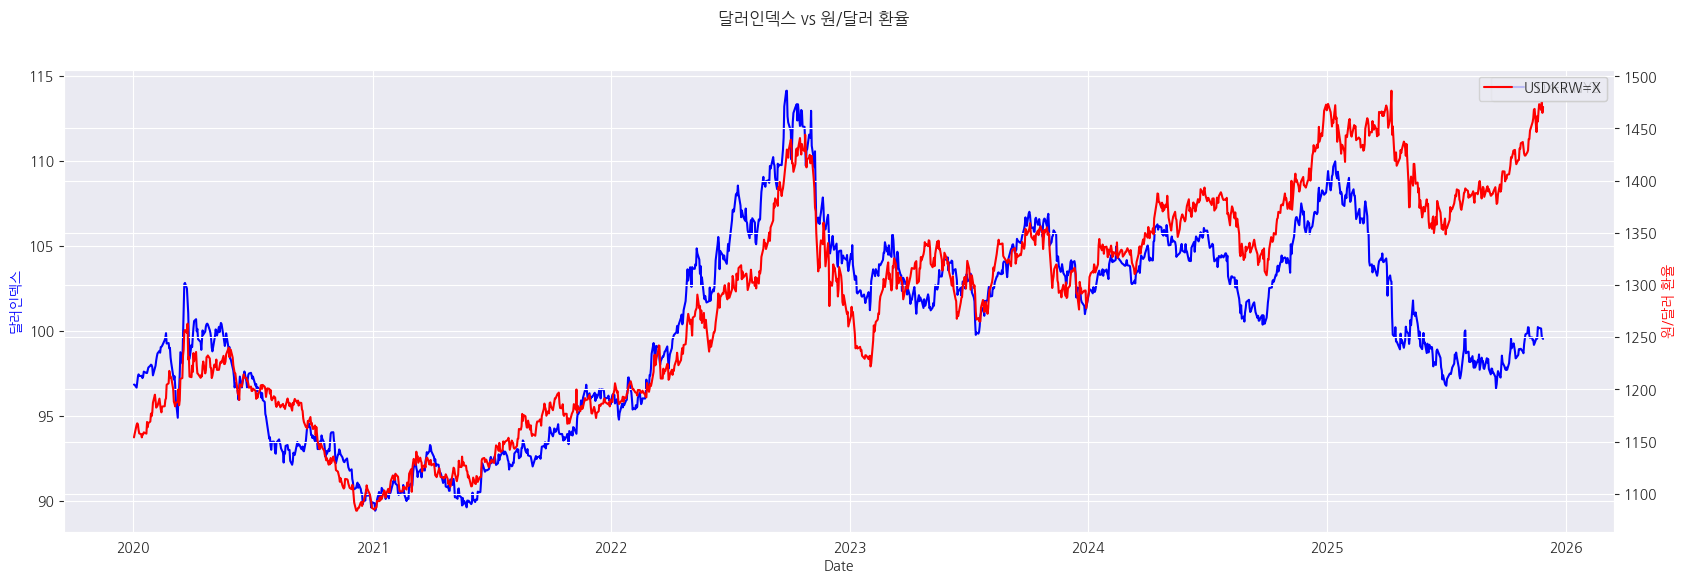

In [4]:
fig, ax1 = plt.subplots(figsize=(20,6))
sns.lineplot(x=df_close.index, y=df_close["Close_DX-Y.NYB"], ax=ax1, label="DX-Y.NYB", color='blue')
ax1.set_ylabel('달러인덱스', color='blue')

ax2 = ax1.twinx()
sns.lineplot(x=df_close.index, y=df_close["Close_USDKRW=X"], ax=ax2, label="USDKRW=X", color='red')
ax2.set_ylabel('원/달러 환율', color='red')

fig.suptitle('달러인덱스 vs 원/달러 환율')
plt.show()


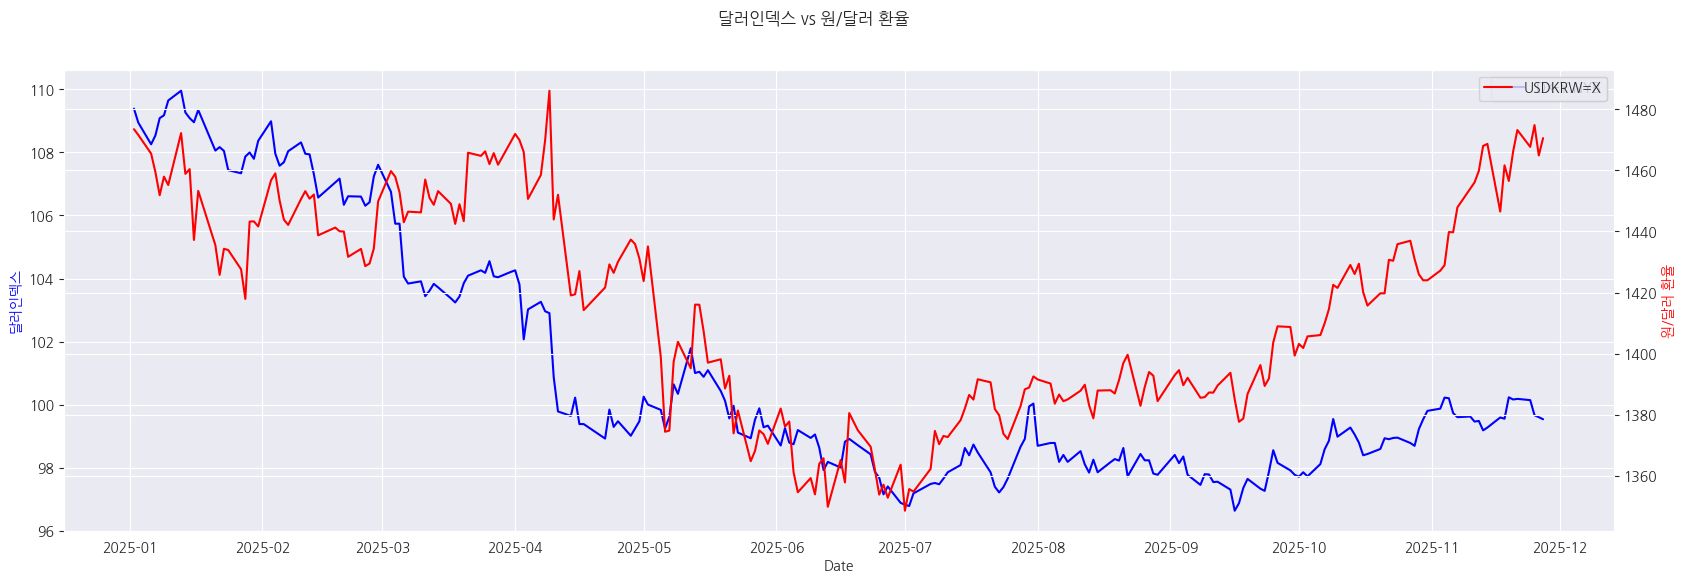

In [5]:
df_tmp = df_close[df_close.index > '2025-01-01']
fig, ax1 = plt.subplots(figsize=(20,6))
sns.lineplot(x=df_tmp.index, y=df_tmp["Close_DX-Y.NYB"], ax=ax1, label="DX-Y.NYB", color='blue')
ax1.set_ylabel('달러인덱스', color='blue')

ax2 = ax1.twinx()
sns.lineplot(x=df_tmp.index, y=df_tmp["Close_USDKRW=X"], ax=ax2, label="USDKRW=X", color='red')
ax2.set_ylabel('원/달러 환율', color='red')

fig.suptitle('달러인덱스 vs 원/달러 환율')
plt.show()

### 왜 2025년 7월이후 달러인덱스와 원달러 환율이 디커플링이 되는가?

- (1) 글로벌 요인 - DXY, 금리 차, 유가
    + 10년채권이 2년채권보다 금리가 높고 2024년 1월1일 기준보다도 유가는 더 내려감
    + 유가가 7월에 잠깐 상승했지만 8월이후 내려감
    + 따라서, 글로벌 요인은 아니고 내부(수급 요인) 가능성이 높음


In [6]:
df_close.tail(1)

,Close_DX-Y.NYB,Close_USDKRW=X
Date,,
2025-11-27,99.532997,1470.589966


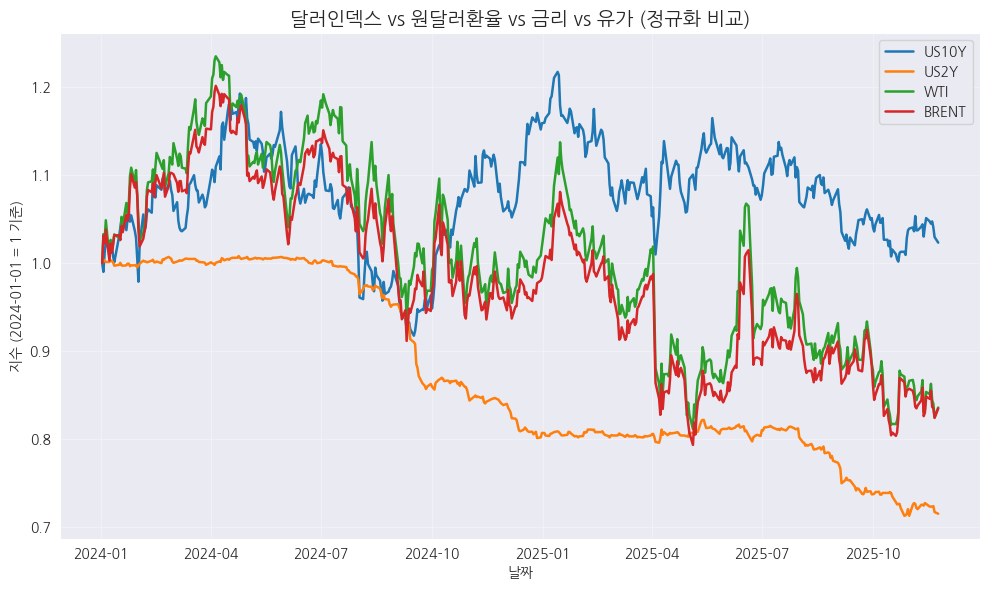

            US10Y   US2Y        WTI      BRENT
Date                                          
2025-11-18  4.123  3.772  60.740002  64.889999
2025-11-19  4.133  3.772  59.439999  63.509998
2025-11-20  4.106  3.775  59.139999  63.380001
2025-11-21  4.063  3.740  58.060001  62.560001
2025-11-24  4.038  3.730  58.840000  63.369999


In [7]:
# -------------------------------
# 1️⃣ 티커 설정
# -------------------------------
tickers = {
    "US10Y": "^TNX",     # 미국 10년물 금리 (%)
    "US2Y": "^IRX",      # 13주 T-bill (근사치로 2년물 대신 사용)
    "WTI": "CL=F",       # WTI 유가 (달러/배럴)
    "BRENT": "BZ=F",     # Brent 유가
    # "DXY": "DX-Y.NYB",   # 달러인덱스
    # "USDKRW": "USDKRW=X" # 원달러 환율
}

# -------------------------------
# 2️⃣ 데이터 다운로드
# -------------------------------
data = {}
for name, ticker in tickers.items():
    df = yf.download(ticker, start="2024-01-01", progress=False, auto_adjust=True)
    df.columns = df.columns.get_level_values(0)
    data[name] = df["Close"]

# -------------------------------
# 3️⃣ 병합 및 전처리
# -------------------------------
merged = pd.DataFrame(data)
merged = merged.dropna()

# -------------------------------
# 3️⃣ 정규화 (각 시계열을 1로 스케일링)
# -------------------------------
df_norm = merged / merged.iloc[0]

# -------------------------------
# 4️⃣ 라인 차트
# -------------------------------
plt.figure(figsize=(10, 6))
for col in df_norm.columns:
    plt.plot(df_norm.index, df_norm[col], label=col, linewidth=1.8)

plt.title("달러인덱스 vs 원달러환율 vs 금리 vs 유가 (정규화 비교)", fontsize=14)
plt.xlabel("날짜")
plt.ylabel("지수 (2024-01-01 = 1 기준)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------------
# 5️⃣ 최근 데이터 확인
# -------------------------------
print(merged.tail())



- (2) 내부 인수급요인(외국인 주식 순매수액, 외환보유액, 경상수지, 한국국고채 금리, 미국금리)
    + 2014년 이후로 대외부채 대비 대외자산이 점차 증가하고 있음. 외국인은 25년 4월 이후로 순매수를 이어가나, 개인들이 팔고 있는 실정임
    + 국가는 계속 외환보유액을 늘려가고 있고 2025년 1월 이후로 경상수지가 증가하고 있음
    + 한국 국고채 2년물 10년물을 본 결과, 10년물 금리가 2년물보다 높지만 2025년 5월보다 2년물, 10년물 금리보다 높음. 상승하고 있는 추세임
    + 한미금리차, 2년물, 10년물 0.9 포인트 차이 남
    + 한미M2 비교해 봐도, 2021년 기준으로 한국은 36%, 미국은 14% 증가함. 한국돈이 그만큼 흔해졌다는 이야기

- 구분                           요인             환율 영향
- 경상수지 흑자 확대              실물경제 안정          ↓ (강세 요인)
- 외국인 순매수, 개인 매도         자본 불균형            ↑ (약세 요인)
- 국고채 금리 상승            유동성 경색, 자금이탈        ↑
- 외환보유액 증가                방어적 조치            중립~↑
- 한미금리차 유지               달러 강세 압력           ↑


- (2-1) 외환수급(외국인 주식 순매수액)
    - 대외자산(Assets)
        +  한국이 전세계에 투자한 돈 / 해외에 가진 금융자산
    - 대외부채(Liabilities)
        +  외국인이 한국에 투자한 돈 / 한국 자산을 외국인이 들고 있는 것
    - 대외자산, 대외부채가 둘다 커지면 자금이 글로벌하게 커지는 국면 (주식/채권 위험선호)
    - 대외자산, 대외부채가 둘다 작아지면 디레버리징 / 긴축 / 위험 회피

In [8]:
df = api.get_statistic_search(통계표코드="311Y001", 주기="Q", 검색시작일자="2010Q1", 검색종료일자="2026Q4")
df['값'] = df['값'].astype(float)
df_comp = df[df['통계항목명1'].isin(['대외금융자산', '대외금융부채'])]
df_comp_fin = df[df['통계항목명1'].isin(['증권투자'])]

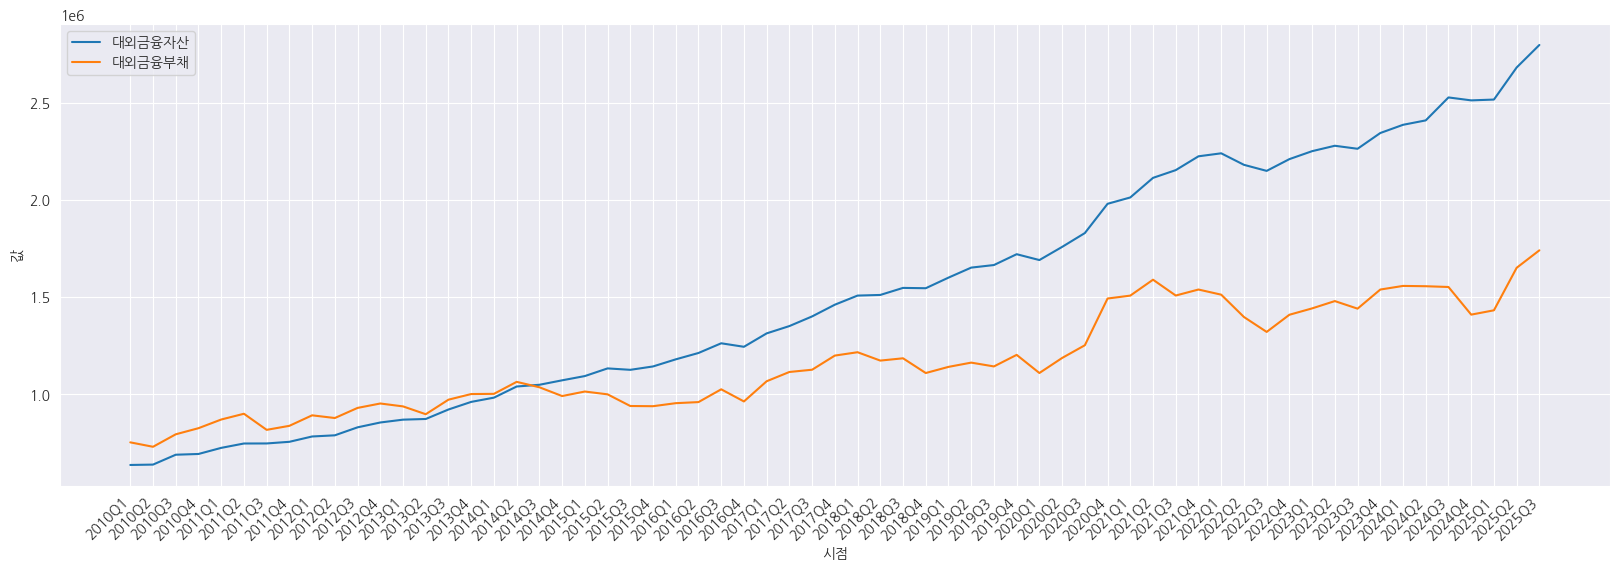

In [9]:
plt.subplots(figsize=(20,6))
sns.lineplot(data=df_comp, x='시점', y='값', hue='통계항목명1')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


- 증권투자
    + https://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020301

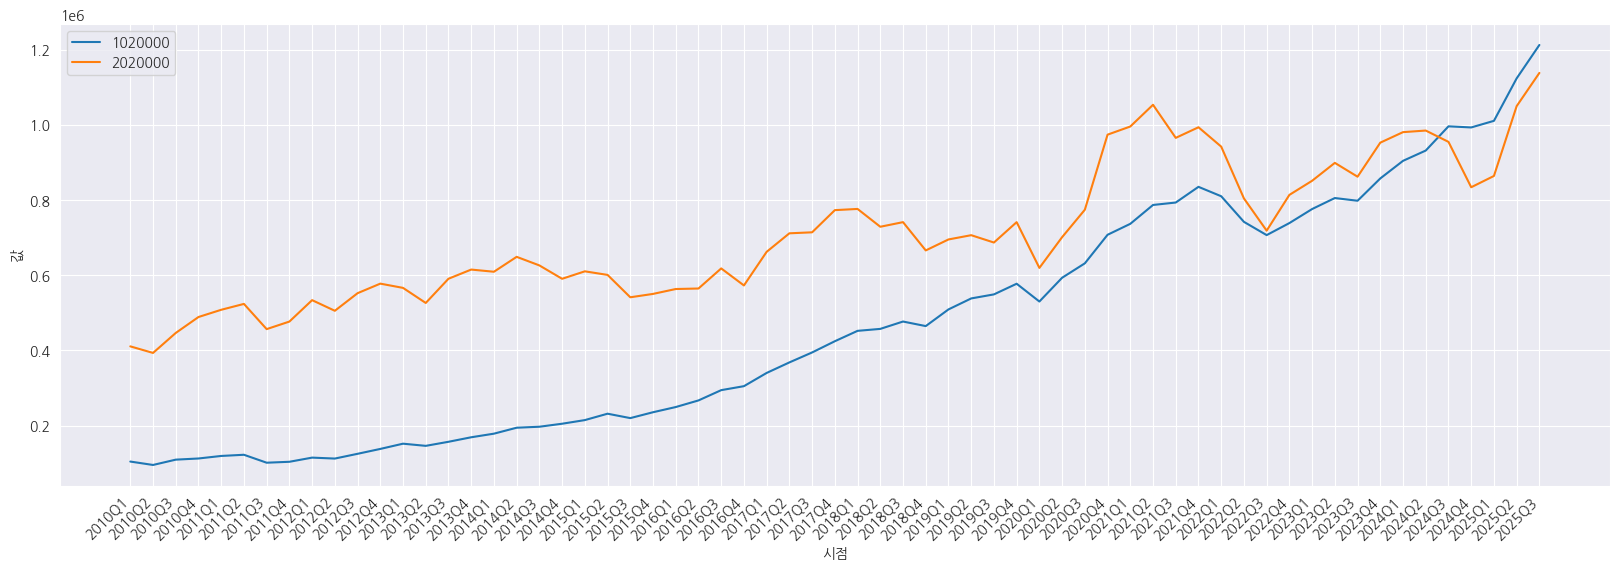

In [10]:
plt.subplots(figsize=(20,6))
sns.lineplot(data=df_comp_fin, x='시점', y='값', hue='통계항목코드1')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

- 일자별 기관, 외국인등등 국장 순매수 (매수 - 매도)

In [11]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import os, time, glob

download_dir = "krx_download"
today = date.today().strftime("%Y%m%d")
options = Options()

##options.add_argument("--headless=new") ## --headless=new
options.add_experimental_option("prefs", {
    "download.default_directory": download_dir,
    "download.prompt_for_download": False,
    "download.directory_upgrade": True,
    "safebrowsing.enabled": True,
    "profile.default_content_settings.popups": 0, # 팝업 차단
})

driver = webdriver.Chrome(options=options)
driver.execute_cdp_cmd("Page.setDownloadBehavior", {"behavior": "allow", "downloadPath": download_dir})

driver.get("https://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201")

## 근처에만 가기
# target = driver.find_element(By.CSS_SELECTOR, "#jsGnbArea > ol > li:nth-child(2) > a")
# actions = ActionChains(driver)
# actions.move_to_element(target).perform기

## 메뉴
els = driver.find_elements(By.CSS_SELECTOR, "#jsMdiMenu > div.lnb_tree > ul > li:nth-child(1) > ul > li:nth-child(2) > div > div.lnb_tree_box > ul > li:nth-child(2) > a")
#print(f"주식 : {els}")
el = WebDriverWait(driver, 20).until(
    EC.element_to_be_clickable(
    (By.CSS_SELECTOR, "#jsMdiMenu > div.lnb_tree > ul > li:nth-child(1) > ul > li:nth-child(2) > div > div.lnb_tree_box > ul > li:nth-child(2) > a")
    )
)
el.click()


els = driver.find_elements(By.CSS_SELECTOR, "#jsMdiMenu > div.lnb_tree > ul > li:nth-child(1) > ul > li:nth-child(2) > div > div.lnb_tree_box > ul > li.on > ul > li:nth-child(3) > a")
#print(f"거래실적 : {els}")
el = WebDriverWait(driver, 20).until(
    EC.element_to_be_clickable(
    (By.CSS_SELECTOR, "#jsMdiMenu > div.lnb_tree > ul > li:nth-child(1) > ul > li:nth-child(2) > div > div.lnb_tree_box > ul > li.on > ul > li:nth-child(3) > a")
    )
)
el.click()


els = driver.find_elements(By.CSS_SELECTOR, "#jsMdiMenu > div.lnb_tree > ul > li:nth-child(1) > ul > li:nth-child(2) > div > div.lnb_tree_box > ul > li.on > ul > li.has5dep.on > ul > li:nth-child(1) > a")
#print(f"투자자별 거래실적 : {els}")
el = WebDriverWait(driver, 20).until(
    EC.element_to_be_clickable(
    (By.CSS_SELECTOR, "#jsMdiMenu > div.lnb_tree > ul > li:nth-child(1) > ul > li:nth-child(2) > div > div.lnb_tree_box > ul > li.on > ul > li.has5dep.on > ul > li:nth-child(1) > a")
    )
)
el.click()

table = WebDriverWait(driver, 20).until(
    EC.presence_of_element_located(
        (By.CSS_SELECTOR, "#jsMdiContent > div > div:nth-child(2) > div.CI-GRID-WRAPPER.CI-GRID-STYLE-NO-ROW-BG > div.CI-GRID-MAIN-WRAPPER > div.CI-GRID-BODY-WRAPPER")  # 실제 테이블 id나 class 확인 필요
    )
)

# 시작일
start = driver.find_element(By.NAME, "strtDd")
start.clear()                 # 기존 값 지우기
start.send_keys("20250101")   # 원하는 날짜
start.send_keys(Keys.TAB)     # 포커스 이동 → onchange trigger

# 종료일
end = driver.find_element(By.NAME, "endDd")
end.clear()
end.send_keys(today)
end.send_keys(Keys.TAB)

## 일별추이
btn = driver.find_element(By.CSS_SELECTOR, "#MDCSTAT022_FORM > div.search_tb > div > table > tbody > tr:nth-child(1) > td > label:nth-child(4)")
btn.click()


# 1) 조회 버튼 기다려서 클릭
WebDriverWait(driver, 20).until(
    EC.element_to_be_clickable((By.ID, "jsSearchButton"))
).click()

# 테이블/조회 전후 텍스트 읽기
time_element = driver.find_element(By.CSS_SELECTOR, "#UNIT-WRAP0 > div > p.CI-MDI-UNIT-TIME")
prev_text = time_element.text

# 텍스트가 변경될 때까지 기다리기
WebDriverWait(driver, 20).until(lambda d: d.find_element(By.CSS_SELECTOR, "#UNIT-WRAP0 > div > p.CI-MDI-UNIT-TIME").text != prev_text)


# 2) 다운로드 버튼
WebDriverWait(driver, 20).until(
    EC.element_to_be_clickable((By.CSS_SELECTOR, "#UNIT-WRAP0 > div > p:nth-child(2) > button.CI-MDI-UNIT-DOWNLOAD > img"))
).click()

# 3) CSV 다운로드
WebDriverWait(driver, 20).until(
    EC.element_to_be_clickable((By.CSS_SELECTOR, "#ui-id-1 > div > div:nth-child(2) > a"))
).click()


new_filename = f"krx_{today}.csv"

# 다운로드 완료 대기
timeout = 60
for _ in range(timeout):
    files = glob.glob(os.path.join(download_dir, f"*{today}.csv")) + \
            glob.glob(os.path.join(download_dir, f"*{today}.xls")) + \
            glob.glob(os.path.join(download_dir, f"*{today}.xlsx"))
    if files:
        old_file = files[0]
        break
    time.sleep(1)
else:
    raise Exception("다운로드 파일 없음 (타임아웃)")

# 파일명 변경
new_path = os.path.join(download_dir, new_filename)
os.rename(old_file, new_path)
#print("다운로드 완료. 새 파일명:", new_path)

In [72]:
# df = pd.read_csv(f'./krx_download/krx_{today}.csv', encoding='cp949')
# df = df.sort_values(by='일자', ascending=True)
#
# plt.subplots(figsize=(20,6))
# sns.barplot(data=df[df['일자'] > '2025/11/01'], x='일자', y='개인', label='개인')
# sns.barplot(data=df[df['일자'] > '2025/11/01'], x='일자', y='외국인 합계', label='외국인 합계')
# sns.barplot(data=df[df['일자'] > '2025/11/01'], x='일자', y='기관 합계', label='기관 합계')
# plt.xticks(rotation=45, ha='right')
# plt.legend()
# plt.title('거래대금 순매수')
# plt.show()

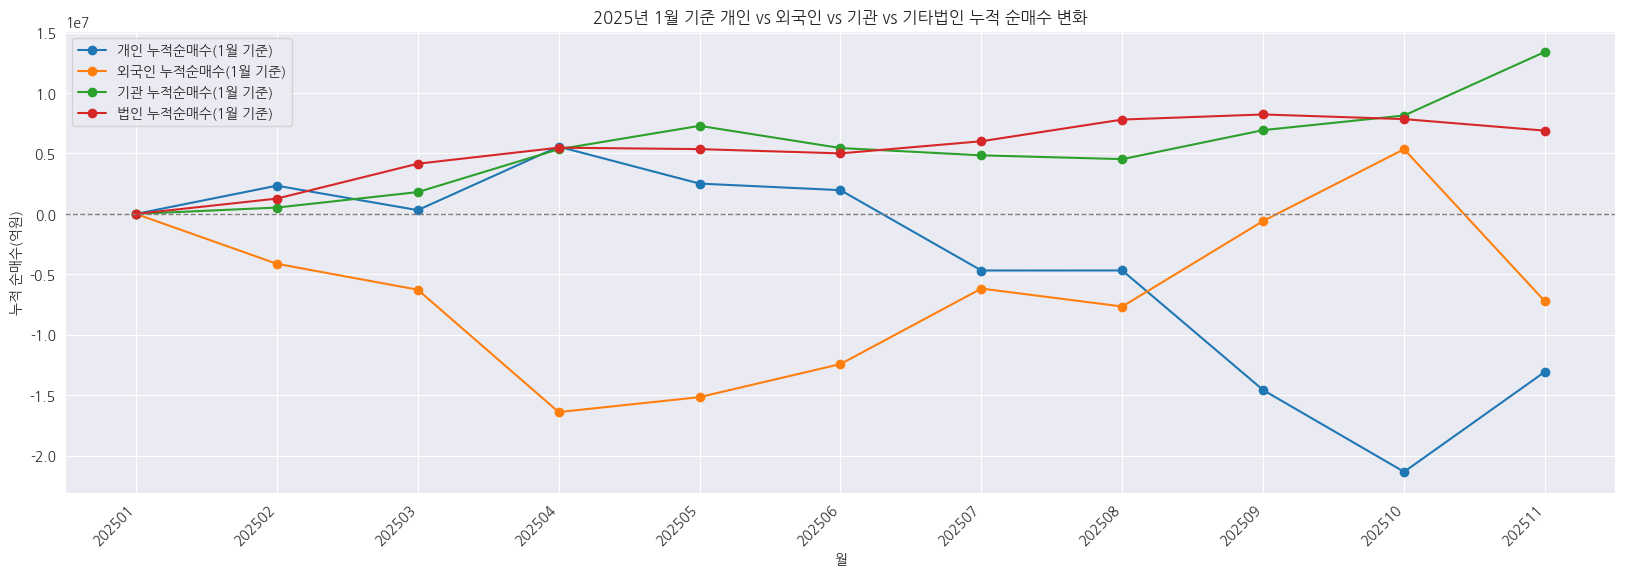

In [12]:
import datetime
df = pd.read_csv(f'./krx_download/krx_{today}.csv', encoding='cp949')
df = df.sort_values(by='일자', ascending=True)

df['ym'] = df['일자'].apply(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d').strftime("%Y%m"))
df_agg = df.groupby('ym').agg({'기관 합계':'sum', '기타법인':'sum', '개인':'sum', '외국인 합계':'sum'})
df_agg.head()

# 개인·외국인 누적 합
df_agg["개인_cum"] = df_agg["개인"].cumsum()
df_agg["외국인_cum"] = df_agg["외국인 합계"].cumsum()
df_agg["기관_cum"] = df_agg["기관 합계"].cumsum()
df_agg["기타법인_cum"] = df_agg["기타법인"].cumsum()

# 2025년 1월 기준 0으로 보정
df_agg["개인_cum_base"] = df_agg["개인_cum"] - df_agg.loc[df_agg.index == "202501", "개인_cum"].values[0]
df_agg["외국인_cum_base"] = df_agg["외국인_cum"] - df_agg.loc[df_agg.index == "202501", "외국인_cum"].values[0]
df_agg["기관_cum_base"] = df_agg["기관_cum"] - df_agg.loc[df_agg.index == "202501", "기관_cum"].values[0]
df_agg["기타법인_cum_base"] = df_agg["기타법인_cum"] - df_agg.loc[df_agg.index == "202501", "기타법인_cum"].values[0]

plt.subplots(figsize=(20,6))
plt.plot(df_agg.index, df_agg["개인_cum_base"], marker="o", label="개인 누적순매수(1월 기준)")
plt.plot(df_agg.index, df_agg["외국인_cum_base"], marker="o", label="외국인 누적순매수(1월 기준)")
plt.plot(df_agg.index, df_agg["기관_cum_base"], marker="o", label="기관 누적순매수(1월 기준)")
plt.plot(df_agg.index, df_agg["기타법인_cum_base"], marker="o", label="법인 누적순매수(1월 기준)")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("2025년 1월 기준 개인 vs 외국인 vs 기관 vs 기타법인 누적 순매수 변화")
plt.xlabel("월")
plt.ylabel("누적 순매수(억원)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

- 외액환보유액

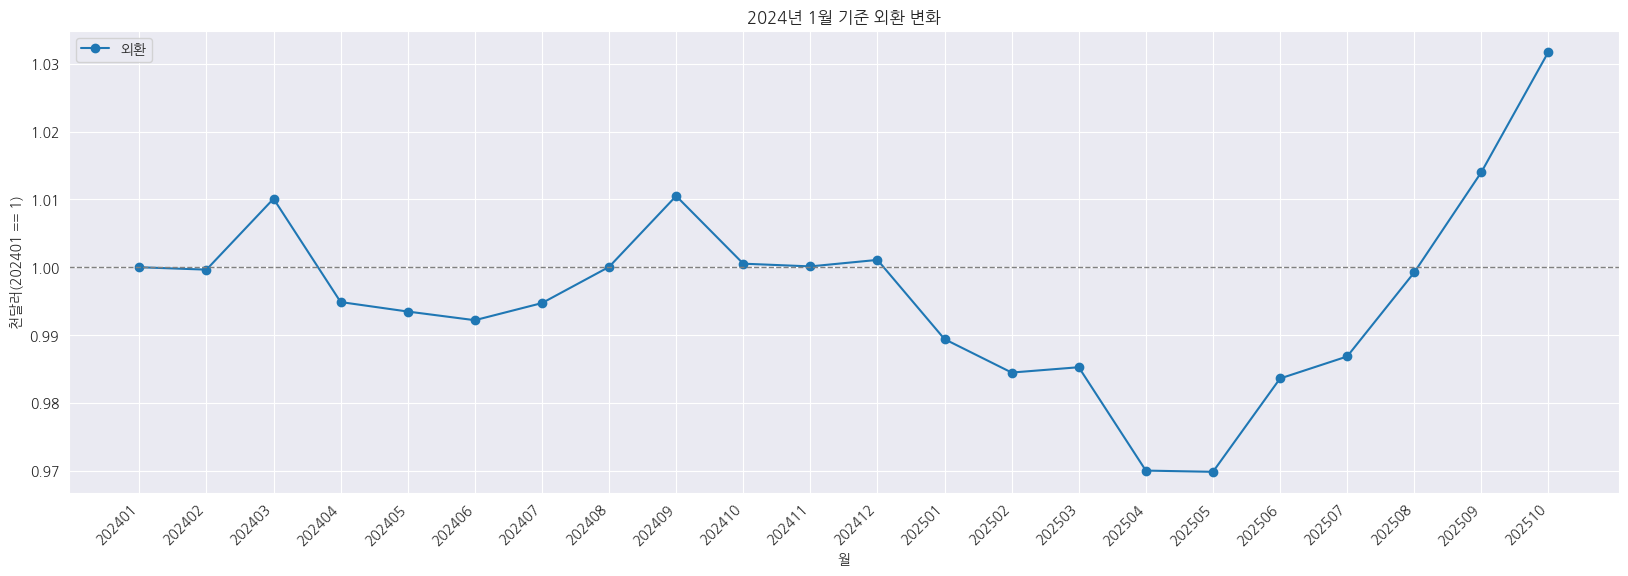

In [13]:
from PublicDataReader import Ecos
service_key = "2G5XUDEN750MGRZM37GF"
api = Ecos(service_key)


df = api.get_statistic_search(통계표코드="732Y001", 주기="M", 검색시작일자="202401", 검색종료일자="202612")
df = df[df['통계항목명1'] == '외환']
df['값'] = df['값'].astype(float)
df['값_norm'] = df['값'] / df['값'].iloc[0]


plt.subplots(figsize=(20,6))
plt.plot(df['시점'], df["값_norm"], marker="o", label="외환")
plt.axhline(1, color="gray", linestyle="--", linewidth=1)
plt.title("2024년 1월 기준 외환 변화")
plt.xlabel("월")
plt.ylabel("천달러(202401 == 1)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()


- 경상수지
    + 실질적인 ‘돈벌이’ — 물건·서비스·이자·배당 같은 소득의 흐름 (상품수지 + 서비스수지 + 본원소득수지 + 이전소득수지)
        + 경상수지가 흑자면? 돈이 유입되어 외환보유액 증가
        + 경상수지가 적자면? 그만큼 외국자본으로 매움
    + 상품(무역)수지 = 상품 수출 - 수입 (삼성폰 수출, 원유 수입)
    + 서비스수지 = 서비스 수출 - 수입 (여행, 운송, 특허)
    + 본원소득수지 = 해외투자소득 (해외 투자 배당금, 이자 수입)
    + 이전소득수지 = 무상거래 (해외 송금, 원조금)

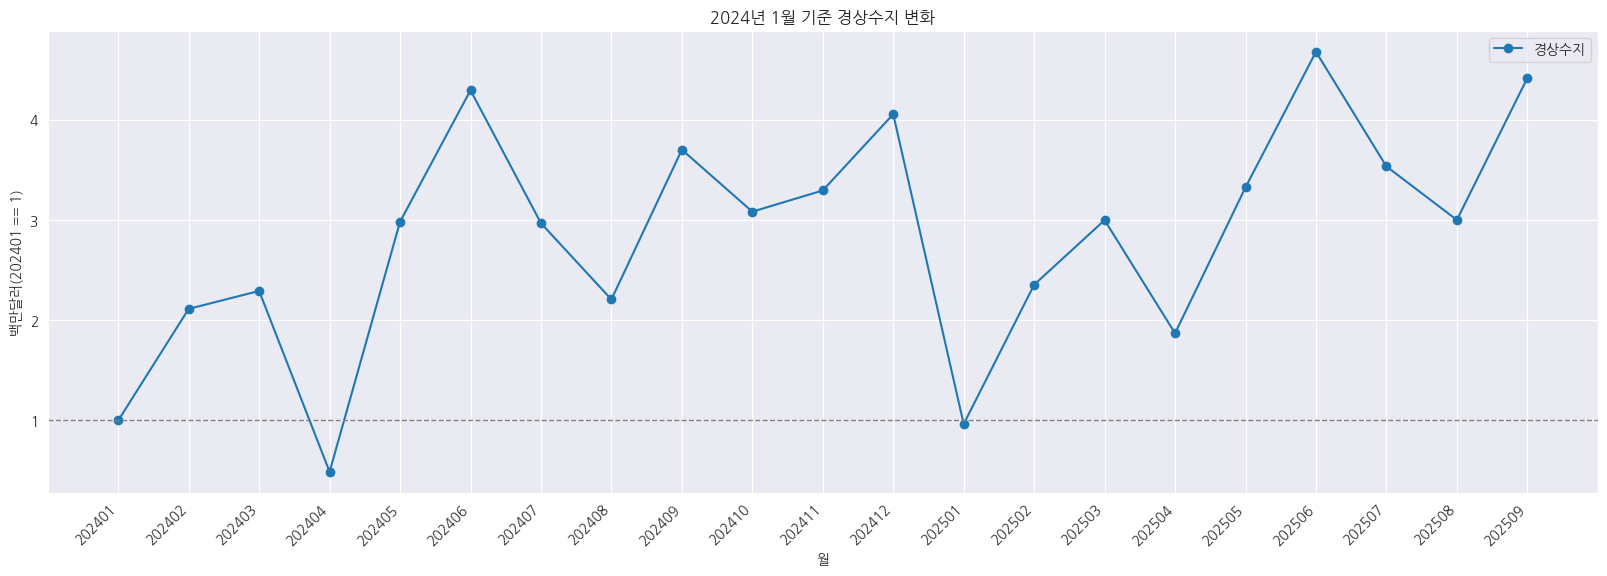

In [14]:
df = api.get_statistic_search(통계표코드="301Y013", 주기="M", 검색시작일자="202401", 검색종료일자="202612")
df_tmp = df[df['통계항목명1'].isin(['자본수지', '경상수지'])].copy()
df_tmp['값'] = df_tmp['값'].astype(float)
df_pivoted = pd.pivot(data=df_tmp, index='시점', columns='통계항목명1', values='값')
df_pivoted['경상수지_norm'] = df_pivoted['경상수지'] / df_pivoted['경상수지'].iloc[0]


plt.subplots(figsize=(20,6))
plt.plot(df_pivoted.index, df_pivoted["경상수지_norm"], marker="o", label="경상수지")
plt.axhline(1, color="gray", linestyle="--", linewidth=1)
plt.title("2024년 1월 기준 경상수지 변화")
plt.xlabel("월")
plt.ylabel("백만달러(202401 == 1)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()


# plt.subplots(figsize=(20,6))
# plt.plot(df_pivoted.index, df_pivoted["자본수지"], marker="o", label="자본수지", color='red')
# plt.axhline(0, color="gray", linestyle="--", linewidth=1)
# plt.title("2024년 1월 기준 자본수지 변화")
# plt.xlabel("월")
# plt.ylabel("백만달러(202401 == 1)")
# plt.xticks(rotation=45, ha='right')
# plt.legend()
# plt.grid(True)
# plt.show()



- 한국 국고채 금리(3y, 10y)

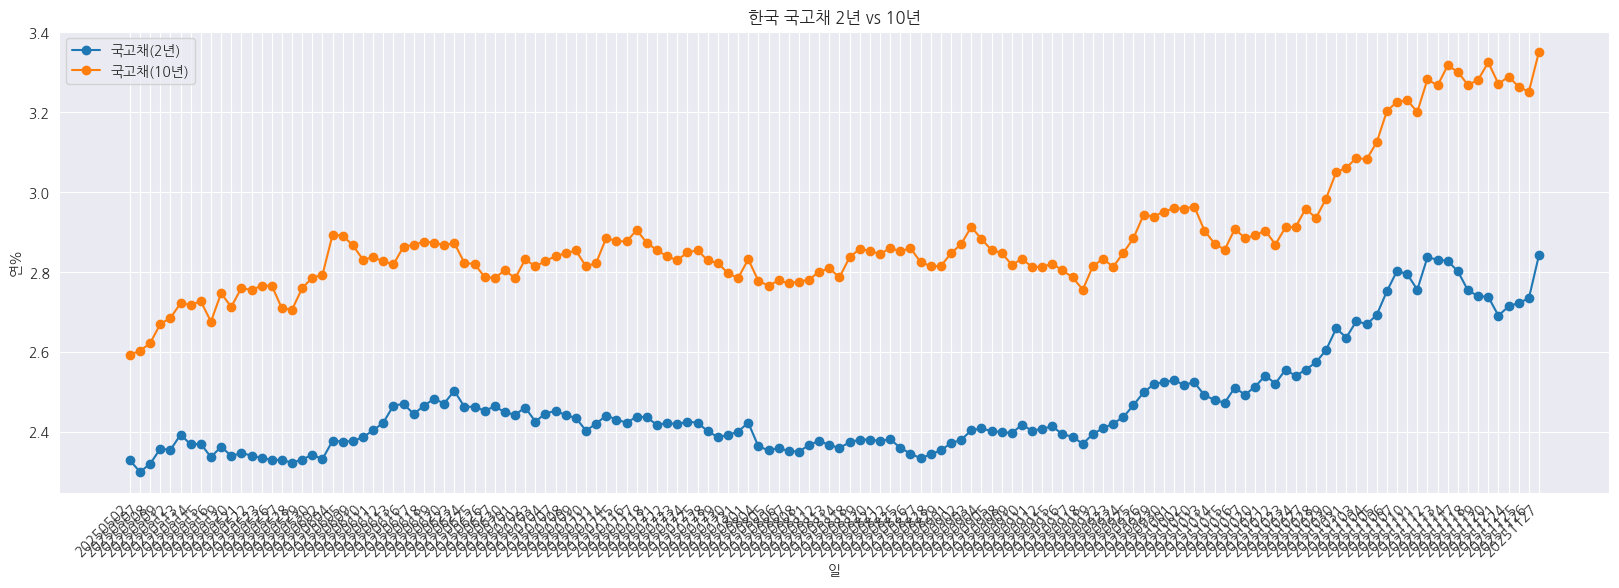

In [15]:
df = api.get_statistic_search(통계표코드="817Y002", 주기="D", 검색시작일자="20250501", 검색종료일자="20261231")
df = df[df['통계항목명1'].isin(['국고채(2년)', '국고채(10년)'])]
df['값'] = df['값'].astype(float)
df_pivoted = pd.pivot(data=df, index='시점', columns='통계항목명1', values='값' )


plt.subplots(figsize=(20,6))
plt.plot(df_pivoted.index, df_pivoted["국고채(2년)"], marker="o", label="국고채(2년)")
plt.plot(df_pivoted.index, df_pivoted["국고채(10년)"], marker="o", label="국고채(10년)")
plt.title("한국 국고채 2년 vs 10년")
plt.xlabel("일")
plt.ylabel("연%")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()


- 미국 - 한국차 금리차

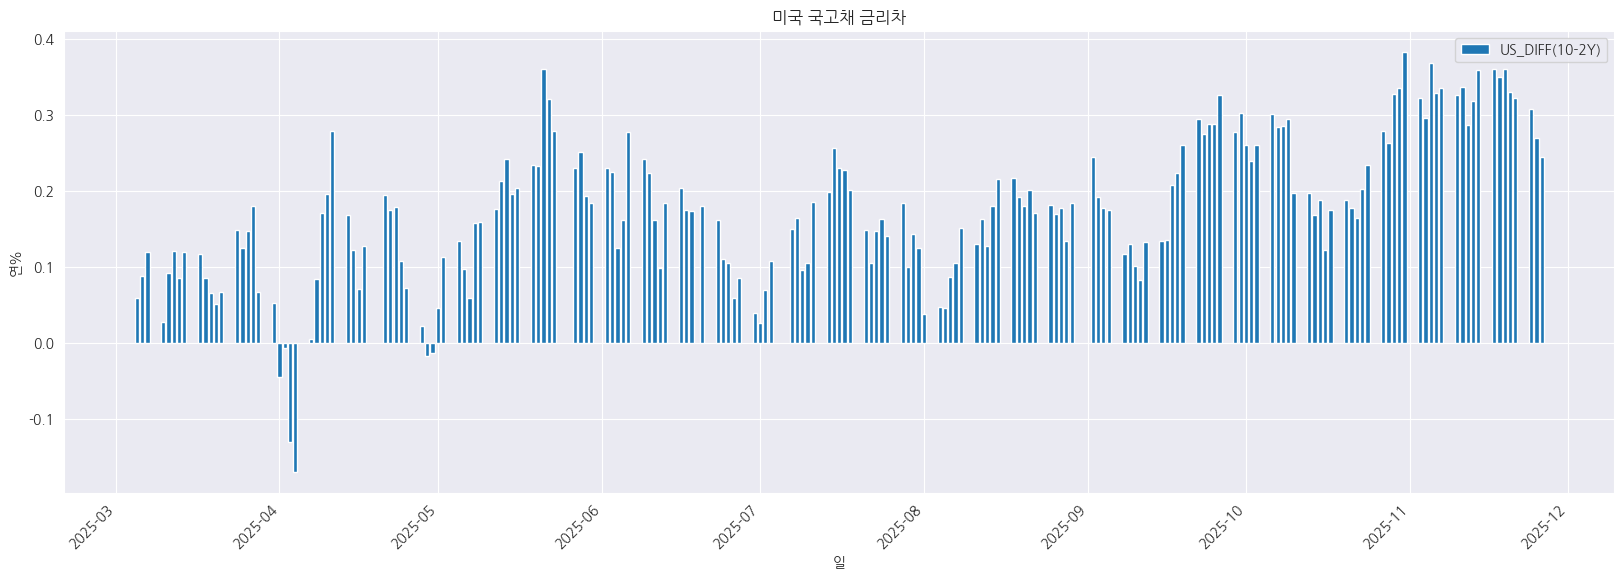

In [23]:
# -------------------------------
# 1️⃣ 티커 설정
# -------------------------------
tickers = {
    "US10Y": "^TNX",  # 미국 10년물 금리 (%)
    "US2Y": "^IRX",  # 13주 T-bill (근사치로 2년물 대신 사용)
}

# -------------------------------
# 2️⃣ 데이터 다운로드
# -------------------------------
data = {}
for name, ticker in tickers.items():
    df = yf.download(ticker, start="2025-03-05", progress=False, auto_adjust=True)
    df.columns = df.columns.get_level_values(0)
    data[name] = df["Close"]

# -------------------------------
# 3️⃣ 병합 및 전처리
# -------------------------------
merged = pd.DataFrame(data)
merged = merged.dropna()
merged['US_DIFF'] = merged['US10Y'] - merged['US2Y']


plt.subplots(figsize=(20,6))
plt.bar(merged.index, merged["US_DIFF"], label="US_DIFF(10-2Y)")
plt.title("미국 국고채 금리차")
plt.xlabel("일")
plt.ylabel("연%")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()


/Users/boycho/PycharmProjects/MacroEconomy/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/boycho/PycharmProjects/MacroEconomy/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/boycho/PycharmProjects/MacroEconomy/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/boycho/PycharmProjects/MacroEconomy/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/boycho/PycharmProjects/MacroEconomy/.venv/lib/python3.12/site-package

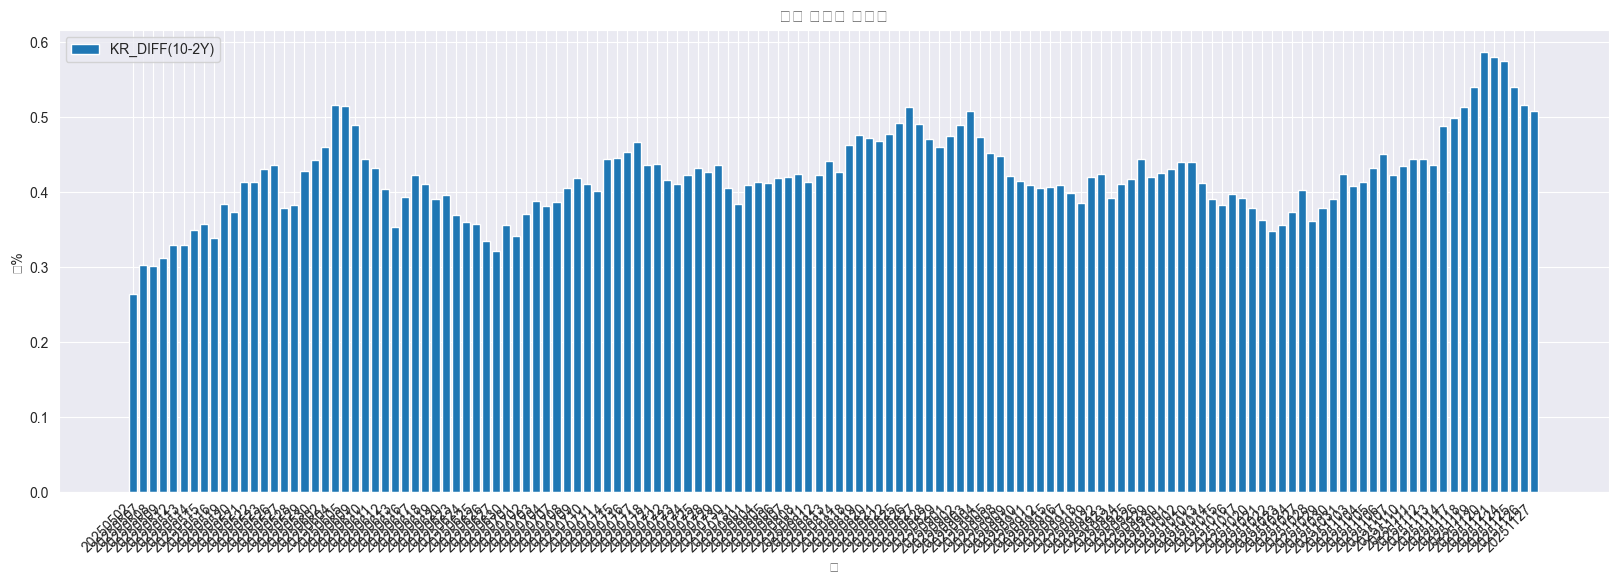

In [30]:
df = api.get_statistic_search(통계표코드="817Y002", 주기="D", 검색시작일자="20250501", 검색종료일자="20261231")
df = df[df['통계항목명1'].isin(['국고채(2년)', '국고채(10년)'])]
df['값'] = df['값'].astype(float)
df_pivoted = pd.pivot(data=df, index='시점', columns='통계항목명1', values='값' )
df_pivoted['국고채_차이'] = df_pivoted['국고채(10년)'] - df_pivoted['국고채(2년)']

plt.subplots(figsize=(20,6))
plt.bar(df_pivoted.index, df_pivoted["국고채_차이"], label="KR_DIFF(10-2Y)")
plt.title("한국 국고채 금리차")
plt.xlabel("일")
plt.ylabel("연%")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

- 한미 M2
    + 응용 프로그램에서 python 3.x 폴더에 들어가 install Certificates.command 실행하면 ssl 인증서 해결

In [25]:
import pandas as pd
from fredapi import Fred

fred_key = "f15197ef9e5831d304aa7e1cefeec806"
fred = Fred(api_key=fred_key)

# 미국 M2 시리즈 ID : WM2NS(미국 M2, 주간)
us_m2 = fred.get_series('WM2NS')
us_m2 = us_m2.resample('ME').last() ## 월말 기준으로 변환
us_m2 = us_m2.reset_index()         # index를 컬럼으로 이동
us_m2.columns = ['시점', 'US(M2)']     # 컬럼 이름 지정
us_m2['시점'] = us_m2['시점'].dt.strftime('%Y%m')

kr_m2 = api.get_statistic_search(통계표코드="101Y002", 주기="M", 검색시작일자="202101", 검색종료일자="202612")
kr_m2 = kr_m2[kr_m2['통계항목명1'] == 'M2(말잔, 원계열)']
kr_m2['값'] = kr_m2['값'].astype(float)
kr_m2 = kr_m2[['시점', '값']].rename(columns={'값':'KR(M2)'})

merged_m2 = kr_m2.merge(us_m2, on='시점', how='left')
merged_m2['KR(M2)%'] = ((merged_m2['KR(M2)'] / merged_m2['KR(M2)'].iloc[0]) -1) * 100
merged_m2['US(M2)%'] = ((merged_m2['US(M2)'] / merged_m2['US(M2)'].iloc[0]) -1) * 100

merged_m2.tail(3)

,시점,KR(M2),US(M2),KR(M2)%,US(M2)%
54,202507,4356000.7,21871.3,34.768355,13.452122
55,202508,4417757.2,21978.2,36.679012,14.006640
56,202509,4447787.0,22092.8,37.608090,14.601100
